# Regression Models

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import joblib
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext watermark

%watermark -v -m -p pandas,numpy,scipy,joblib,xgboost,seaborn,matplotlib,warnings

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.32.0

pandas    : 1.4.2
numpy     : 1.22.3+mkl
scipy     : 1.8.0
joblib    : 1.1.0
xgboost   : 1.5.2
seaborn   : 0.11.2
matplotlib: 3.5.1
warnings  : unknown

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 62 Stepping 4, GenuineIntel
CPU cores   : 32
Architecture: 64bit



In [2]:
# Load the RandomForest Model pipeline
rf_pipe = joblib.load('oe_rf_depth15_660k.sav')

In [3]:
X_cols=['miles', 'year', 'make', 'model', 'trim', 'vehicle_type', 'body_type',
       'drivetrain', 'fuel_type', 'engine_block', 'engine_size',
       'transmission', 'doors', 'cylinders', 'city_mpg', 'highway_mpg',
       'base_exterior_color', 'base_interior_color', 'is_certified', 'state',
       'carfax_1_owner', 'carfax_clean_title']

In [4]:
trim_lookup = pd.read_csv('trim_lookup.csv')
# use this method in the frontend (UI interface) to get the default trim if use doesn't provide the trim information
def getTrim(make, model):
    trim = ''
    try:
        trim= trim_lookup[(trim_lookup.make==make) & (trim_lookup.model==model)]['trim'].values[0]
    except:
        trim = model
    return trim


vin_lookup_year_df = pd.read_csv('vin_lookup_year.csv')
# Get the default vehicle specifications from based on Make, Model, Model Year and Trim.
def getVehicleDetails(make, model,trim, year=None):
    vehicleDetails={}
    vehicleDetails_col=['vehicle_type', 'body_type', 'drivetrain',
       'fuel_type', 'engine_block', 'engine_size', 'transmission', 'doors',
       'cylinders', 'city_mpg', 'highway_mpg','base_exterior_color','base_interior_color','state']
    
   
    if year is None:
        vehicleDetails=vin_lookup_year_df[(vin_lookup_year_df.make==make) &\
                             (vin_lookup_year_df.model==model) &\
                             (vin_lookup_year_df.trim==trim)].groupby(vehicleDetails_col).size().reset_index().sort_values(0, ascending=False).drop(0,axis=1).head(1).to_dict('r')[0]
        
    else:
        vehicleDetails=vin_lookup_year_df[(vin_lookup_year_df.year==year) &\
                           (vin_lookup_year_df.make==make) &\
                           (vin_lookup_year_df.model==model) &\
                           (vin_lookup_year_df.trim==trim)].groupby(vehicleDetails_col).size().reset_index().sort_values(0, ascending=False).drop(0,axis=1).head(1).to_dict('r')[0]
    if len(vehicleDetails)>0:
        return vehicleDetails
    else:
        return vin_lookup_NO_year_df.groupby(vehicleDetails_col).size().reset_index().sort_values(0, ascending=False).drop(0,axis=1).head(1).to_dict('r')[0]

In [5]:
def imputeX(single_predict):
    
    
    if not single_predict.get('trim'):
        single_predict['trim']=getTrim(single_predict['make'],single_predict['model'])
        
    available_cols = list(single_predict.keys())
    
    default_values = getVehicleDetails(single_predict['make'],single_predict['model'], single_predict['trim'], single_predict['year'])
    missing_cols = [x for x in X_cols if x not in available_cols]

    for col in missing_cols:
        single_predict[col]=default_values.get(col,0)

    single_predict_df = pd.DataFrame(columns=single_predict.keys(), data = np.array(list(single_predict.values())).reshape(1, len(single_predict)))

    single_predict_df.miles= pd.to_numeric(single_predict_df.miles, errors='coerce')
    single_predict_df.year= pd.to_numeric(single_predict_df.year, errors='coerce')
    single_predict_df.engine_size= pd.to_numeric(single_predict_df.engine_size, errors='coerce')
    single_predict_df.doors= pd.to_numeric(single_predict_df.doors, errors='coerce')
    single_predict_df.cylinders = pd.to_numeric(single_predict_df.cylinders, errors='coerce')
    single_predict_df.city_mpg = pd.to_numeric(single_predict_df.city_mpg, errors='coerce')
    single_predict_df.highway_mpg = pd.to_numeric(single_predict_df.highway_mpg, errors='coerce')
    single_predict_df.is_certified = pd.to_numeric(single_predict_df.is_certified, errors='coerce')
    single_predict_df.carfax_1_owner = pd.to_numeric(single_predict_df.carfax_1_owner, errors='coerce')
    single_predict_df.carfax_clean_title= pd.to_numeric(single_predict_df.carfax_clean_title, errors='coerce')

    single_predict_df = single_predict_df[X_cols]

    return single_predict_df   

In [11]:
def estimateVehileValue(X):
    
    estimated_value = rf_pipe.predict(X)
    x_treanformed=rf_pipe['preprocessor'].transform(X)
    rf_estimators = rf_pipe['estimator'].estimators_

    preds=[]
    for estimator in rf_estimators:
        preds.append(estimator.predict(x_treanformed))
        
      
    data = [x[0] for x in preds]
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=data, kde=True, bins=25)
    
    # 95%, 2 sigma confidence interval(CI)
    ci = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
    return (estimated_value[0], ci)

In [7]:
single_predict= {'make':'Toyota',
'model':'Corolla',
'miles':50000,
'year':2018,
'base_exterior_color':'Silver', 
'base_interior_color':'Gray'
}

single_predict_df = imputeX(single_predict)
single_predict_df

,miles,year,make,model,trim,vehicle_type,body_type,drivetrain,fuel_type,engine_block,...,doors,cylinders,city_mpg,highway_mpg,base_exterior_color,base_interior_color,is_certified,state,carfax_1_owner,carfax_clean_title
0,50000,2018,Toyota,Corolla,LE,Car,Sedan,FWD,Unleaded,I,...,4.0,4.0,28.0,36.0,Silver,Gray,0,FL,0,0


In [8]:
single_predict_partial_data= {'make':'Toyota',
'model':'Corolla',
'miles':50000,
'year':2018,
'base_exterior_color':-1, 
'base_interior_color':-1,
        'vehicle_type':-1, 
                 'body_type':-1,
       'drivetrain':-1, 
                 'fuel_type':-1, 
                 'engine_block':-1, 
                 'engine_size':-1,
       'transmission':-1, 
                 'doors':-1, 
                 'cylinders':-1, 
                 'city_mpg':-1, 
                 'highway_mpg':-1,
                 'state':-1
}
single_predict_partial_data = imputeX(single_predict_partial_data)
single_predict_partial_data

,miles,year,make,model,trim,vehicle_type,body_type,drivetrain,fuel_type,engine_block,...,doors,cylinders,city_mpg,highway_mpg,base_exterior_color,base_interior_color,is_certified,state,carfax_1_owner,carfax_clean_title
0,50000,2018,Toyota,Corolla,LE,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,0,-1,0,0


## Get vehicle value estimation from RandomForest

(19964.853406112128, (19884.784737707796, 20044.922074516453))

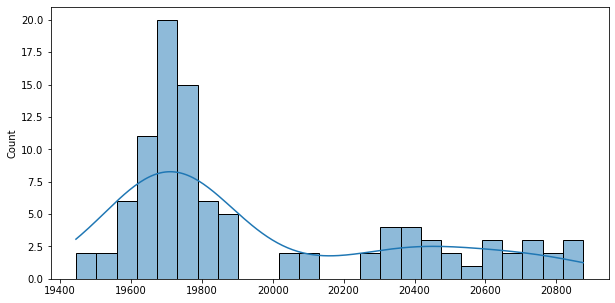

In [12]:
estimateVehileValue(single_predict_df)

(28149.855099338092, (26971.548172029845, 29328.16202664634))

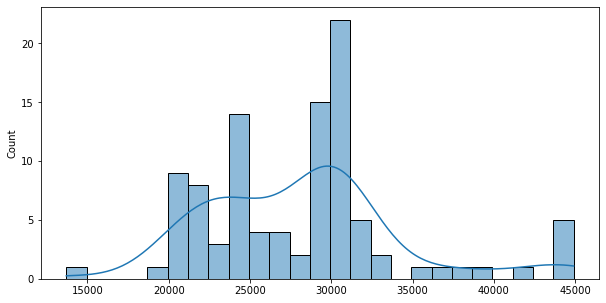

In [13]:
estimateVehileValue(single_predict_partial_data)

```
# with all values filled
(19797.43846916645, (19735.943956108833, 19858.932982224072))
with color
(19797.43846916645, (19735.943956108833, 19858.932982224072))
without color, filled with default values
(19797.43846916645, (19735.943956108833, 19858.932982224072))
#without default specs
(26537.93841612829, (25259.103301522457, 27816.773530734103))
```